## LC Model Search Framework

* Compare 1 season (summer) and 4 temporal steps
* Compare 0 - 1500 training training samples per class in 100 sample increments
* CNN component and RNN components in isolation
* regular CNN+RNN vs conv2dlstm and RNN vs just conv2dLSTM
* Compare to scikit-learn methods using same val and test datasets
* Compare best model across time
    * if major decrease in accuracy then consider training on both 2010 and 2011 data for initial time step
        * consider training on 1999 data to see how it changes the model

In [1]:
import comet_ml
from comet_ml import Experiment
import datetime
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

Using TensorFlow backend.


In [2]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

Assign your specific GPU so we don't overlap

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [5]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
class_dict = util.indexed_dictionary

Ingest the landsat imagery stacked into yearly seasonal tiles

In [6]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

### Load pixels from shapefiles

In [7]:
train_gdf = gpd.read_file('../train_buffered_points140520.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['tile_name']))

random.shuffle(train_px)

len(train_px), train_px[0]

(9000, ((1407, 3674), '028012'))

In [8]:
val_gdf = gpd.read_file('../val_buffered_points140520_val.shp')
val_px = []

per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    if not row['dubious']:
        total_per_class_count[int(row['label'])] = total_per_class_count[int(row['label'])] + 1
        if per_class_count[int(row['label'])] < 125:
            per_class_count[int(row['label'])] = per_class_count[int(row['label'])] + 1
            val_px.append(((row['row'], row['col']), row['tile_name']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

(750, ((2399.0, 1688.0), '028012'))

In [9]:
total_per_class_count, per_class_count

([141, 147, 133, 133, 130, 129], [125, 125, 125, 125, 125, 125])

In [10]:
val_gdf.head()

,canopy,col,label,row,tile_name,x,y,manual_val,dubious,reject,geometry
0,0.0,3884.0,0.0,1617.0,028012,1750950.0,1466280.0,0,0,0,POLYGON ((-76.61112678048431 34.64445257944547...
1,0.0,4553.0,0.0,693.0,028011,1771020.0,1644000.0,0,0,0,POLYGON ((-75.98675821109941 36.16139632039837...
2,0.0,1140.0,0.0,1835.0,029011,1818630.0,1609740.0,0,0,0,POLYGON ((-75.54709982307929 35.77251818591635...
3,0.0,3023.0,0.0,3896.0,028011,1725120.0,1547910.0,0,0,0,POLYGON ((-76.70836461104372 35.40562568571118...
4,0.0,989.0,0.0,3414.0,028012,1664100.0,1412370.0,0,0,0,POLYGON ((-77.66217912565303 34.32496740952818...


### Create the RNN

In [11]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp

In [12]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    
    
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(input_tensor_tile)
    
    first_batch_norm = BatchNormalization()(cnn_layer1)
    
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(first_batch_norm)
    
    second_batch_norm = BatchNormalization()(cnn_layer2)
    
    first_pool3D = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(second_batch_norm)
    
    cnn_layer3 = ConvLSTM2D(64, kernel_size=2, activation='elu', data_format='channels_last', 
                            return_sequences=False)(first_pool3D)
    
    first_pool2D = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (cnn_layer3)
    
    third_batch_norm = BatchNormalization()(first_pool2D)
    
    flatten = Flatten()(third_batch_norm)
    
    #concat = concatenate([final_block, flatten])
    
    concat = flatten
    
    denselayer = Dense(64, activation="elu")(concat)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

In [13]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    
    
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(input_tensor_tile)
    
    first_batch_norm = BatchNormalization()(cnn_layer1)
    
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(first_batch_norm)
    
    second_batch_norm = BatchNormalization()(cnn_layer2)
    
    first_pool3D = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(second_batch_norm)
    
    cnn_layer3 = ConvLSTM2D(64, kernel_size=2, activation='elu', data_format='channels_last', 
                            return_sequences=True)(first_pool3D)
    
    third_batch_norm = BatchNormalization()(cnn_layer3)
    
    #first_pool2D = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (third_batch_norm)
    #second_pool3D = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(third_batch_norm)
    
    flatten = Flatten()(third_batch_norm)
    
    #concat = concatenate([final_block, flatten])    
    denselayer = Dense(64, activation="elu")(flatten)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

In [14]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True, data_format='channels_last')(input_tensor_tile)
    first_batch_norm = BatchNormalization()(cnn_layer1)
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True, data_format='channels_last') (first_batch_norm)
    second_batch_norm = BatchNormalization()(cnn_layer2)
    maxpool = MaxPooling3D(pool_size=(1, 2, 2), strides=None, padding='same') (second_batch_norm)
    cnn_layer3 = ConvLSTM2D(64, kernel_size=2, activation='elu', return_sequences=False, data_format='channels_last') (second_batch_norm)
    flatten = Flatten()(cnn_layer3)
    #concat = concatenate([final_block, flatten])
    
    denselayer = Dense(64, activation="relu")(flatten)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

In [15]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True)(input_tensor_tile)
    # batch norm
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=False) (cnn_layer1)
    maxpool = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (cnn_layer2)
    flatten = Flatten()(maxpool)
    concat = concatenate([final_block, flatten])
    
    denselayer = Dense(64, activation="elu")(concat)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Start the experiments here:

In [16]:
exp_name = 'rcnn_full_testing'
model_name = 'rcnn_full'

In [17]:
experiment = Experiment(api_key="rMFbl2RlGxNuyyL37dE7qPSfE",
                        project_name="chronos", workspace="clifgray")

COMET INFO: old comet version (3.1.6) detected. current: 3.1.7 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/clifgray/chronos/3d8580f5cc54413aac7cbe63e7708484



In [18]:
experiment.add_tag(exp_name)

In [19]:
tile_size = 13
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
epochs = 60
batch_size = 25
steps_division_factor = 10

In [20]:
model = make_MLT_dense((len(tiles['028012']),7),(len(tiles['028012']),tile_size,tile_size,7), class_count)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rnn_input (InputLayer)          (None, 5, 7)         0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 5, 12)        960         rnn_input[0][0]                  
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 5, 19)        0           rnn_input[0][0]                  
                                                                 lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)       

#### Train the Model

In [21]:
filepath = 'model_search/' +  model_name + '--' + exp_name + '.hdf5' #your filepath here
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [22]:
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy'}, metrics={'landcover':['accuracy']}, loss_weights={"landcover":1})

In [23]:
util.class_to_index

{11: 0,
 21: 3,
 22: 1,
 23: 1,
 24: 1,
 31: 4,
 41: 2,
 42: 2,
 43: 2,
 52: 2,
 71: 3,
 81: 3,
 82: 3,
 90: 2,
 95: 5}

In [24]:
train_time_start = datetime.datetime.now()

history = model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                steps_per_epoch=len(train_px) // batch_size // steps_division_factor, epochs=epochs, verbose=1,
                validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                validation_steps=len(val_px) // batch_size,
                callbacks=callbacks_list) 

train_time_stop = datetime.datetime.now()
training_time = train_time_stop - train_time_start

Instructions for updating:
Use tf.cast instead.


COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/60
 1/36 [..............................] - ETA: 4:50 - loss: 1.8549 - acc: 0.2000

COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE


36/36 [==============================] - 16s 440ms/step - loss: 0.7596 - acc: 0.7044 - val_loss: 0.2850 - val_acc: 0.9080

Epoch 00001: val_acc improved from -inf to 0.90800, saving model to model_search/rcnn_full--rcnn_full_testing.hdf5
Epoch 2/60
36/36 [==============================] - 7s 182ms/step - loss: 0.4301 - acc: 0.8456 - val_loss: 0.3627 - val_acc: 0.8760

Epoch 00002: val_acc did not improve from 0.90800
Epoch 3/60
36/36 [==============================] - 6s 178ms/step - loss: 0.3971 - acc: 0.8822 - val_loss: 0.2753 - val_acc: 0.9080

Epoch 00003: val_acc improved from 0.90800 to 0.90800, saving model to model_search/rcnn_full--rcnn_full_testing.hdf5
Epoch 4/60
36/36 [==============================] - 6s 178ms/step - loss: 0.3355 - acc: 0.8733 - val_loss: 0.1544 - val_acc: 0.9440

Epoch 00004: val_acc improved from 0.90800 to 0.94400, saving model to model_search/rcnn_full--rcnn_full_testing.hdf5
Epoch 5/60
36/36 [==============================] - 6s 174ms/step - loss: 0.3

36/36 [==============================] - 6s 172ms/step - loss: 0.1473 - acc: 0.9478 - val_loss: 0.1482 - val_acc: 0.9533

Epoch 00042: val_acc did not improve from 0.96800
Epoch 43/60
36/36 [==============================] - 6s 172ms/step - loss: 0.1352 - acc: 0.9611 - val_loss: 0.1168 - val_acc: 0.9613

Epoch 00043: val_acc did not improve from 0.96800
Epoch 44/60
36/36 [==============================] - 6s 172ms/step - loss: 0.1440 - acc: 0.9478 - val_loss: 0.1207 - val_acc: 0.9587

Epoch 00044: val_acc did not improve from 0.96800
Epoch 45/60
36/36 [==============================] - 6s 171ms/step - loss: 0.1296 - acc: 0.9556 - val_loss: 0.1031 - val_acc: 0.9613

Epoch 00045: val_acc did not improve from 0.96800
Epoch 46/60
36/36 [==============================] - 6s 169ms/step - loss: 0.1106 - acc: 0.9600 - val_loss: 0.1029 - val_acc: 0.9667

Epoch 00046: val_acc did not improve from 0.96800
Epoch 47/60
36/36 [==============================] - 6s 172ms/step - loss: 0.1264 - acc: 0.9

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


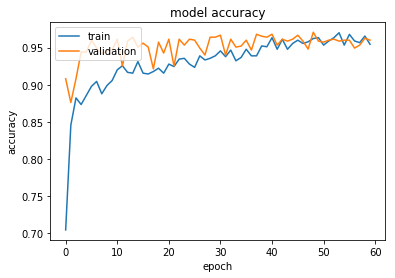

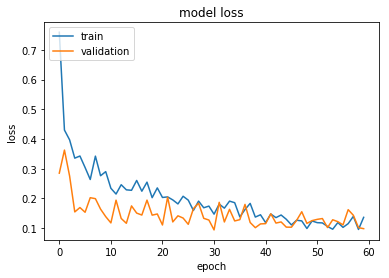

In [25]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
experiment.log_figure(figure=plt, figure_name="model_acc")
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
experiment.log_figure(figure=plt, figure_name="model_loss")
plt.show()

In [26]:
model = keras.models.load_model(filepath)

# Evaluate model

In [27]:
inference_time_start = datetime.datetime.now()

predictions = model.predict_generator(generator = tile_gen.tile_generator(val_px, batch_size=50, flatten=True, canopy=True), steps=len(val_px) // 50, verbose=1)

inference_time_stop = datetime.datetime.now()
inference_time = inference_time_stop - inference_time_start

eval_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)

15/15 [==============================] - 3s 205ms/step


In [28]:
450 * 60 *60 * 24

38880000

In [29]:
predictions.shape

(750, 6)

In [30]:
lc_predictions = predictions

In [31]:
lc_lab = np.empty(lc_predictions.shape[0])
#canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        #canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_lc
        count += 1
label_index = lc_lab.reshape(len(val_px)*1*1)
pred_index = np.argmax(lc_predictions, axis=-1).reshape(len(val_px)*1*1)

Accuracy is 0.9706666666666667
per_class_acc 0.992
per_class_acc 0.984
per_class_acc 0.928
per_class_acc 0.976
per_class_acc 0.952
per_class_acc 0.992


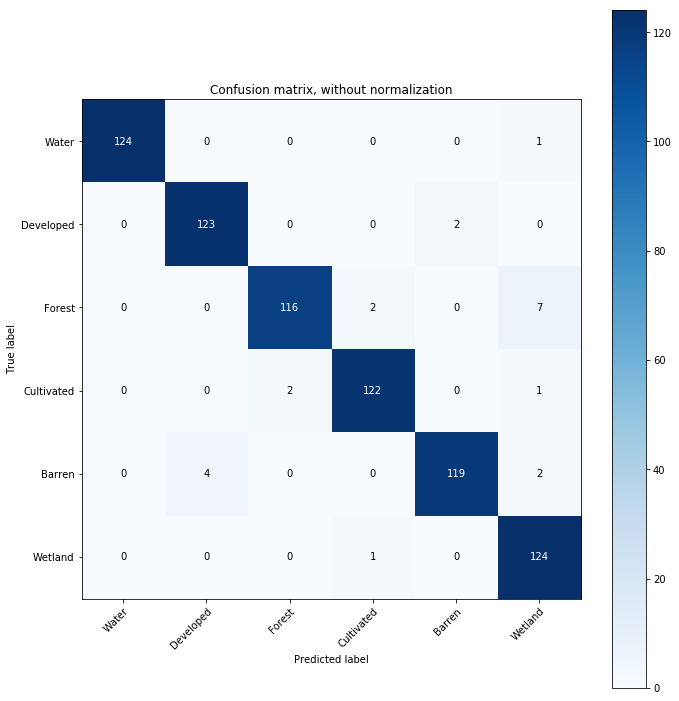

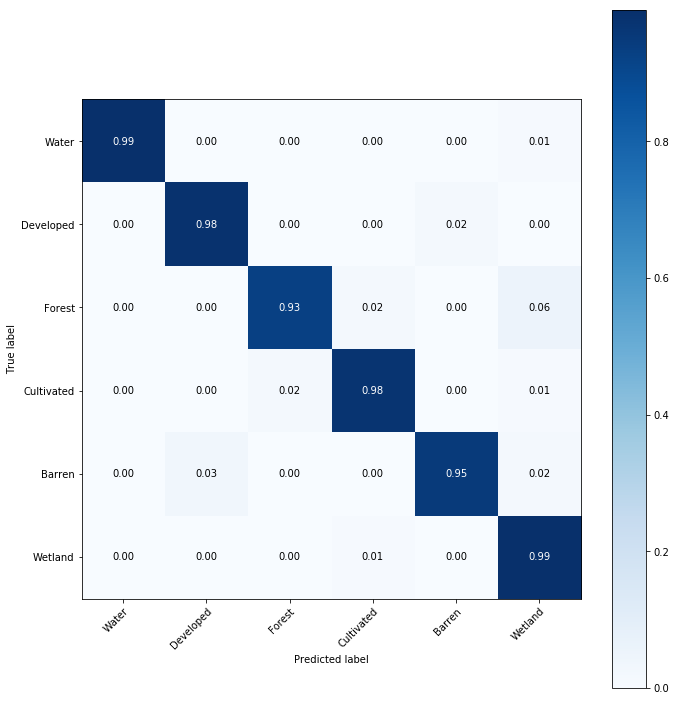

In [32]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
_, users_acc, prod_acc = util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict)
experiment.log_figure(figure=plt, figure_name="unnorm_conf_matrix")
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict,
                      normalize=True,
                          title=" ")
experiment.log_figure(figure=plt, figure_name="norm_conf_matrix")
count = 0
per_class_acc = [0] * 6
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        per_class_acc[int(label_index[i])] = per_class_acc[int(label_index[i])] + 1
        count+=1

val_accuracy=count/len(label_index)
class_acc_dict = {}
print("Accuracy is",val_accuracy)
# this is producer's accuracy
for idx, class_correct in enumerate(per_class_acc):
    class_acc_dict[class_dict[idx]] = round(class_correct/(int(len(label_index)/class_count)),4)
    print('per_class_acc', class_correct/(per_class_count[idx]))

Calculate the accuracy per class
Calculate overall accuracy
Add training samples
add epochs
add tile size

In [33]:
import pandas as pd
import seaborn as sns

experiment_df = pd.DataFrame(columns=['exp_name','model_name','time_steps','train_count','overall_acc', 
                                      'epochs', 'tile_size', 'training_time', 'inference_time',
                                      'water_acc_prod','dev_acc_prod', 'forest_acc_prod', 'cult_acc_prod', 'barren_acc_prod', 'wetland_acc_prod',
                                      'water_acc_user','dev_acc_user', 'forest_acc_user', 'cult_acc_user', 'barren_acc_user', 'wetland_acc_user'])   

In [34]:
experiment_df.loc[len(experiment_df)] = [exp_name, model_name, len(tiles['028012']), len(train_px)/class_count, val_accuracy, 
                                         epochs, tile_size, training_time, inference_time] + list(np.round(prod_acc,3)) + list(np.round(users_acc,3))


In [35]:
experiment_df.tail(5)

,exp_name,model_name,time_steps,train_count,overall_acc,epochs,tile_size,training_time,inference_time,water_acc_prod,...,forest_acc_prod,cult_acc_prod,barren_acc_prod,wetland_acc_prod,water_acc_user,dev_acc_user,forest_acc_user,cult_acc_user,barren_acc_user,wetland_acc_user
0,rcnn_full_testing,rcnn_full,5,1500.0,0.970667,60,13,00:06:39.006919,00:00:03.080796,0.992,...,0.928,0.976,0.952,0.992,1.0,0.969,0.983,0.976,0.983,0.919


In [36]:
experiment_df.to_csv('model_search/' + model_name + '--' + exp_name + '.csv')

In [37]:
all_exps = pd.read_csv('model_search/' + 'all_model_runs.csv')
all_exps = pd.concat([all_exps,experiment_df], ignore_index=True)
all_exps.to_csv('model_search/' + 'all_model_runs.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [38]:
params = {
    "exp_name":exp_name,
    "model_name":model_name,
    "landsat_tiles":tiles,
    "cnn_tile_size":tile_size,
    "class_dict":class_dict,
    "batch_size":batch_size,
    "steps_division_factor":steps_division_factor,
    "lc_validation_acc":val_accuracy
}
experiment.log_parameters(params)

In [39]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/clifgray/chronos/3d8580f5cc54413aac7cbe63e7708484
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [60]                  : (0.7044444452557299, 0.9699999921851687)
COMET INFO:     batch_acc [240]           : (0.20000000298023224, 1.0)
COMET INFO:     batch_loss [240]          : (0.006386416032910347, 1.8549020290374756)
COMET INFO:     epoch_duration [60]       : (6.070556303020567, 18.306427757022902)
COMET INFO:     loss [60]                 : (0.09535319552135964, 0.7595831313067012)
COMET INFO:     val_acc [60]              : (0.8759999970595042, 0.9706666648387909)
COMET INFO:     val_loss [60]             : (0.09378384370356799, 0.36265923430522284)
COMET INFO:     validate_batch_acc [180]  : (0.800000011920929, 1.0)
COMET INFO: